In [77]:
import numpy as np
from numpy import asarray
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import skimage
from skimage.segmentation import clear_border
from skimage import data, exposure, img_as_float
from skimage.filters import threshold_otsu
from skimage import measure
from skimage.measure import label,regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import blend_modes
import plotly.graph_objects as go

# 5, 6, 7, 8 y 22

# angulo de elevacion

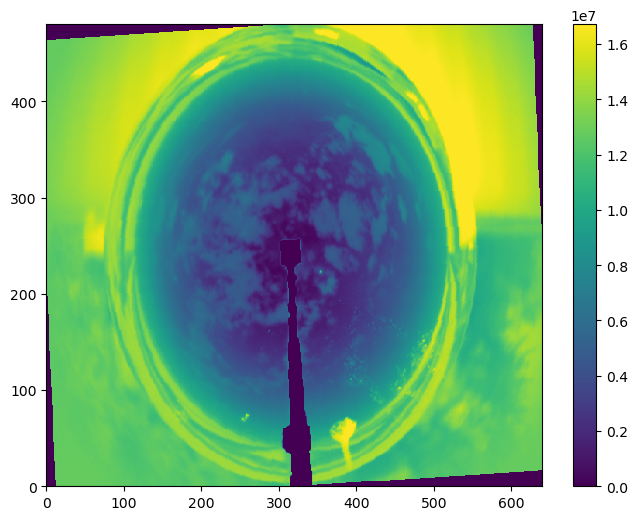

In [78]:
# filepath = '20230807_normal/20230807152030.png'
# filepath = '20230807_normal/20230807152100.png'

# filepath = '20230807_normal/20230807163300.png'
# filepath = '20230807_normal/20230807100030.png'
# filepath = '20230807_normal/20230807192000.png'
filepath = '20230807_normal/20230807175600.png'
# filepath = '20230807_normal/20230807210600.png'
# filepath = '20230807_normal/20230807211330.png'

img = Image.open(filepath)
img = asarray(img)
raw = img

camara = Image.open('camara.png')
camara = asarray(camara)
slicee = camara[:,:,3]
img = img* slicee

from_array = Image.fromarray(img)
im_flip = ImageOps.flip(from_array)
im_rotate = im_flip.rotate(-3, center=(314, 235))
img = asarray(im_rotate)

# print(img.shape)
plt.figure(figsize=(8,6))
# ÷plt.pcolormesh(img, cmap='Greys_r')
plt.pcolormesh(img)
plt.colorbar()

In [79]:
def TwoDToRBGA (img):
    background_img_raw = img
    background_img = np.array(background_img_raw)  # Inputs to blend_modes need to be numpy arrays.
    # Rescale the pixel values to the range [0, 255]
    scaled_img = ((background_img - np.min(background_img)) / (np.max(background_img) - np.min(background_img)) * 255).astype(np.uint8)
    # Create an RGBA image with the rescaled content
    rgba_image = np.zeros((background_img.shape[0], background_img.shape[1], 4), dtype=np.uint8)
    # Copy the rescaled values to the first three channels (RGB)
    rgba_image[:, :, 0:3] = scaled_img[:, :, np.newaxis]
    # Set the alpha channel to a constant value (255 for fully opaque)
    alpha_value = 255
    rgba_image[:, :, 3] = alpha_value
    # Now 'rgba_image' is an RGBA image with dimensions (480, 640, 4)
    # plt.imshow(rgba_image)
    return rgba_image

rgba_image = TwoDToRBGA (img)

In [80]:
def create_radial_gradient(size, center, radius):

    y, x = np.ogrid[:size[0], :size[1]]
    distance = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)
    gradient = 1 - np.clip(distance / radius, 0, 1)
    return gradient

image_size = img.shape
# gradient_center = (221, 345)  # Center of the gradient
gradient_center = (235, 314)  # Center of the gradient
gradient_radius = 200  # Radius of the gradient
gradient_1 = create_radial_gradient(image_size, gradient_center, gradient_radius)
rgba_grad_1 = TwoDToRBGA (gradient_1)

gradient_radius = 250  # Radius of the gradient
gradient_2 = create_radial_gradient(image_size, gradient_center, gradient_radius)
rgba_grad_2 = TwoDToRBGA (gradient_2)
# plt.imshow(rgba_grad_2)

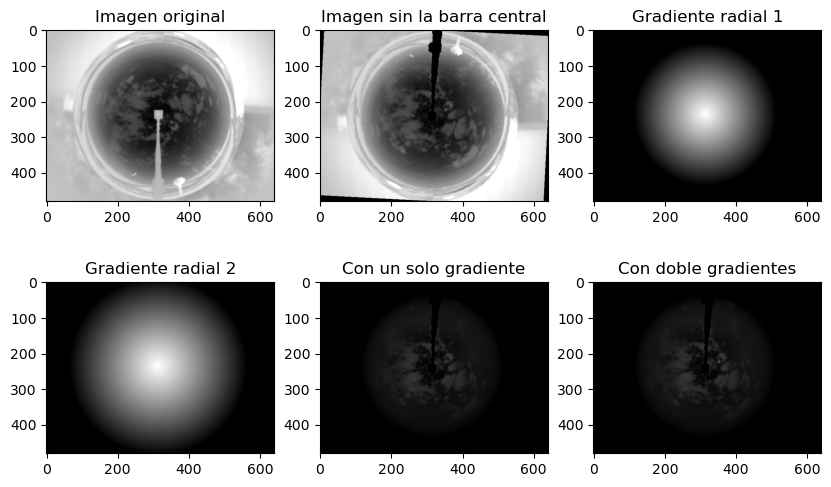

In [81]:
def multiply_with_gradient(image, gradient, opacity):
    # Inputs to blend_modes need to be floats.
    background_img_float = image.astype(float)
    foreground_img_float = gradient.astype(float)
    blended_img_float = blend_modes.multiply(background_img_float, foreground_img_float, opacity)

    # Convert blended image back into PIL image
    blended_img = np.uint8(blended_img_float)  # Image needs to be converted back to uint8 type for PIL handling.
    blended_img_raw = Image.fromarray(blended_img)  # Note that alpha channels are displayed in black by PIL by default.
    return blended_img

first_grad = multiply_with_gradient(rgba_image, rgba_grad_1, 1)
second_grad = multiply_with_gradient(first_grad, rgba_grad_2, 0)


# Display the original image, gradient, and the multiplied result
plt.figure(figsize=(10,6))
plt.subplot(2, 3, 1)
plt.imshow(raw, cmap='gray')
plt.title('Imagen original')

plt.subplot(2, 3, 2)
plt.imshow(img, cmap='gray')
plt.title('Imagen sin la barra central')

plt.subplot(2, 3, 3)
plt.imshow(gradient_1, cmap='gray')
plt.title('Gradiente radial 1')

plt.subplot(2, 3, 4)
plt.imshow(gradient_2, cmap='gray')
plt.title('Gradiente radial 2')

plt.subplot(2, 3, 5)
plt.imshow(first_grad, cmap='gray')
plt.title('Con un solo gradiente')

plt.subplot(2, 3, 6)
plt.imshow(second_grad, cmap='gray')
plt.title('Con doble gradientes')

plt.show()

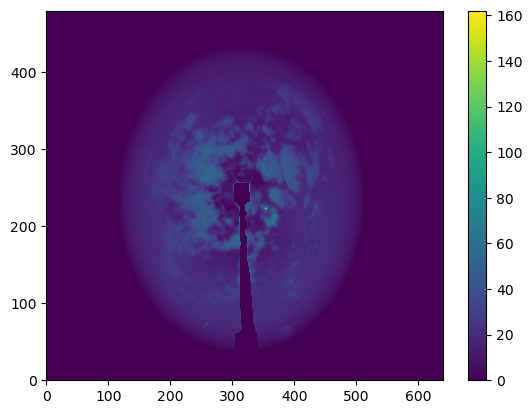

In [82]:
plt.pcolormesh(second_grad[:,:,0])
plt.colorbar()

Average of non-zero values: 19.058505978256335
Standard deviation of non-zero values: 10.008377629046805


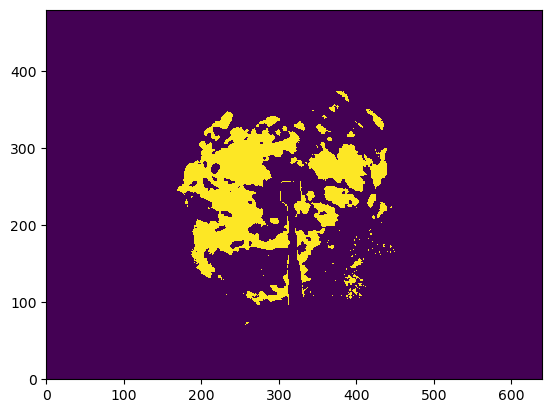

In [83]:
# mask =  (img < 30000) & (img > 10000)
# calc average over square surrounding circle
twoDArray = second_grad[:,:,0]
non_zero_mask = twoDArray != 0
non_zero_values = twoDArray[non_zero_mask]
average_non_zero = np.mean(non_zero_values)
std_non_zero = np.std(non_zero_values)
print("Average of non-zero values:", average_non_zero)
print("Standard deviation of non-zero values:", std_non_zero)
mask =  (second_grad[:,:,0] > average_non_zero+std_non_zero*2/3)
# mask =  (second_grad[:,:,0] > average_non_zero+5)

# mask =  (second_grad[:,:,0] > average_non_zero+5)

# print(np.average(twoDArray[:,:]>0))
# avg_square = np.average(second_grad[163:450,86:400,0])
# print(avg_square)
# mask =  (second_grad[:,:,0] > avg_square+8)
# mask =  (second_grad[:,:,0] > average_non_zero+5)

mask.shape
mask = clear_border(mask)
plt.pcolormesh(mask)

In [84]:
# # mask =  (new_img < 30000) & (new_img > 500)
# mask =  new_img > 2500
# plt.pcolormesh(mask)

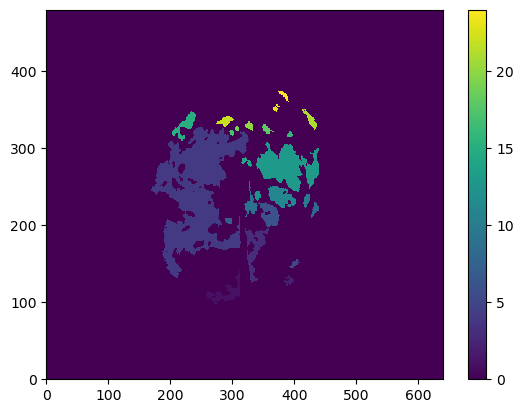

In [85]:
def remove_small(slc, c=0.0001):
    new_slc = slc.copy()
    labels = label(slc,connectivity=1,background=0)
    rps = regionprops(labels)
    areas = np.array([r.area for r in rps])
    idxs = np.where(areas/(640*480) < c)[0]
    for i in idxs:
        new_slc[tuple(rps[i].coords.T)] = 0
    return new_slc

big_mask = remove_small(mask)
mask_labeled = label(big_mask)
plt.pcolormesh(mask_labeled)
plt.colorbar()

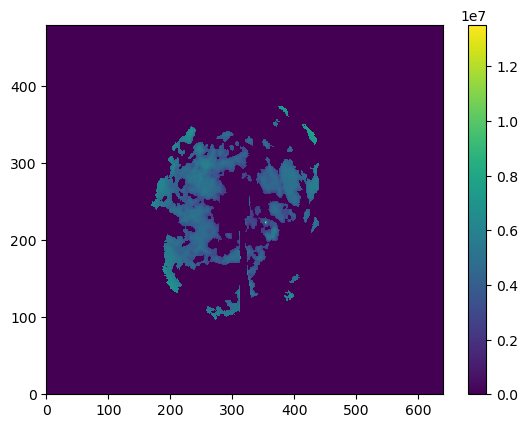

In [86]:
# small_area_img = first_grad[:,:,0] * big_mask
small_area_img = img * big_mask
plt.pcolormesh(small_area_img)
plt.colorbar()

Text(0.5, 1.0, 'Filtered Image')

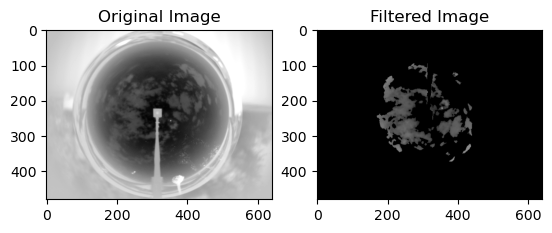

In [87]:
plt.subplot(1, 2, 1)
plt.imshow(raw, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(small_area_img, cmap='gray')
plt.title('Filtered Image')

Text(0.5, 1.0, 'Imagen final')

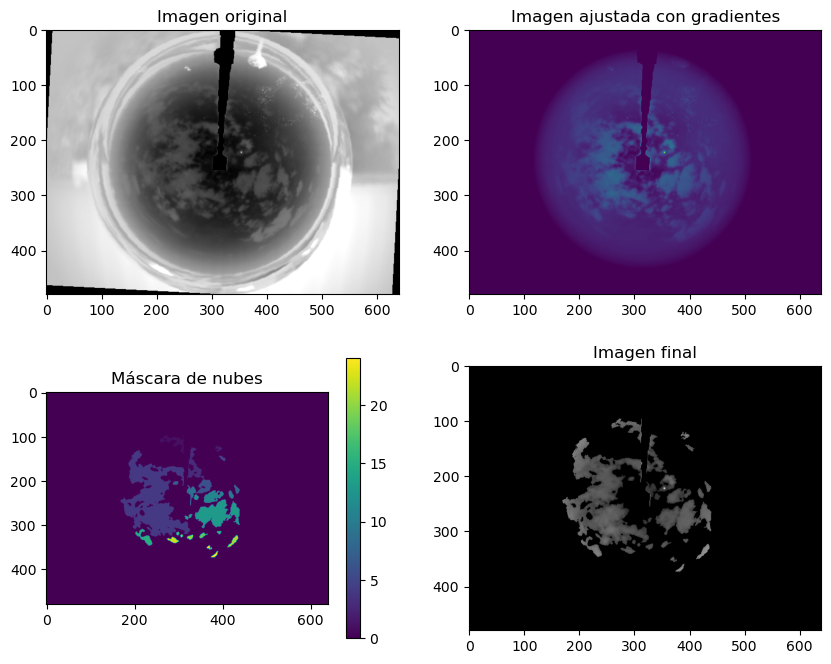

In [91]:
plt.figure(figsize=(10,8))

plt.subplot(2, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Imagen original')

plt.subplot(2, 2, 2)
plt.imshow(second_grad[:,:,0])
plt.title('Imagen ajustada con gradientes')

plt.subplot(2, 2, 3)
plt.imshow(mask_labeled)
plt.colorbar()
plt.title('Máscara de nubes')

plt.subplot(2, 2, 4)
plt.imshow(small_area_img, cmap='gray')
plt.title('Imagen final')

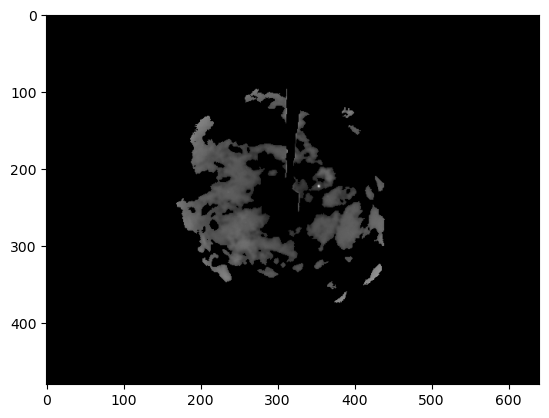

In [89]:
output_img = TwoDToRBGA(small_area_img)
plt.imshow(output_img)

In [90]:
# plt.imshow(mask_labeled)

labels = label(output_img,connectivity=1,background=0)
rps = regionprops(labels)
areas = np.array([r.area for r in rps])
areas


array([3.07203e+05, 6.00000e+00, 3.00000e+00, ..., 3.00000e+00,
       3.00000e+00, 3.00000e+00])